# Import Library

In [ ]:
import torch, os, time, copy
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage
import numpy as np

class Helper():
    @staticmethod
    def load_tensor(path):
        return torch.load(path).to(torch.float32).numpy()
    
    @staticmethod
    def show_slice(vol, liv, ves, num_slice=20):
        for _ in range(num_slice):
            i = np.random.randint(0, vol.shape[0])
            print(i)
            fig, ax = plt.subplots(1,3, figsize=(10,7))
            ax[0].imshow(vol[i],cmap='gray')
            ax[0].contour(liv[i]>0)
            ax[0].contour(ves[i]>0)
            
            ax[1].imshow(liv[i],cmap='gray')
            ax[2].imshow(ves[i],cmap='gray')
            plt.show()


# Load dataset

In [ ]:
from torch.utils.data import Dataset

class Bloodset(Dataset):
    def __init__(self):
        super().__init__()
        self.reset()

    def reset(self):
        self.volume = []
        self.liver = []
        self.vessel = []

    def add(self, volume, liver, vessel):
        self.volume.append(volume)
        self.liver.append(liver)
        self.vessel.append(vessel)

    def __getitem__(self, i):
        return self.volume[i], self.liver[i], self.vessel[i]

    def __len__(self):
        return len(self.volume)

In [ ]:
DIR = '/content/drive/My Drive/Tumor_src/Datasets/3Dircad/PTH'

start = time.time()
train_set = Bloodset()
for i in range(1,21):
    print('Loading patient #{}'.format(i))
    volume = Helper.load_tensor(str(DIR) + '/VOLUME/volume_' + str(i) + '.pth')
    liver = Helper.load_tensor(str(DIR) + '/LIVER/volume_' + str(i) + '.pth')
    vessel = Helper.load_tensor(str(DIR) + '/VESSEL/volume_' + str(i) + '.pth')
    train_set.add(volume, liver, vessel)
print('Loading time: {:.2f} s'.format(time.time() - start))

# Load real distance voxel (mm) - (thickness slice - pixel spacing 0 - pixel spacing 1) 
voxel_size_lst = '/content/drive/My Drive/Tumor_src/Datasets/3Dircad/voxel_size.pth'
voxel_size_lst = torch.load(voxel_size_lst).numpy()

Loading patient #1
Loading patient #2
Loading patient #3
Loading patient #4
Loading patient #5
Loading patient #6
Loading patient #7
Loading patient #8
Loading patient #9
Loading patient #10
Loading patient #11
Loading patient #12
Loading patient #13
Loading patient #14
Loading patient #15
Loading patient #16
Loading patient #17
Loading patient #18
Loading patient #19
Loading patient #20
Loading time: 123.46 s


# Data Interpolation

In [ ]:
import numpy as np 
from scipy import ndimage

def zoom_data(data, voxel_size, is_label, factor=1.0, zoom_func=ndimage.zoom, **kwargs):
    '''
    :param 
        - data: volume or label - numpy array
        - voxel_size: real distance of voxel - (depth, height, width)
        - is_label: interpolate for label if True
        - factor: rate of size out with size in of volume - (a float number) 
        - zoom_func: zoom function - default is scipy.ndimage.zoom()
        - karg: a dict of options to pass to zoom_func.
    '''
    if is_label:
        data[data>0] = 255

    # compute factor size
    zoom_factor = voxel_size[0] / factor , voxel_size[1] / factor, voxel_size[2] / factor

    # zoom data
    vol_out = zoom_func(data, zoom_factor, **kwargs)

    # Make width and height is a even number
    if vol_out.shape[1] % 2 == 1:
        vol_out = vol_out[:, 0:-1, :]
    if vol_out.shape[2] % 2 == 1:
        vol_out = vol_out[:, :, 0:-1]

    if is_label:
        vol_out[vol_out <= 100] = 0
        vol_out[vol_out > 100] = 1
        
    return vol_out

# Get bounding box 3D

In [ ]:
def bounding_box(tensor):
    '''
    Finds two corner points that specifies bounding box of input.
    Args:
        input: 3D-tensor needs to be determined bounding box. - numpy
    Returns:
        tuple of indices specifies bounding box, (xstart, ystart, zstart, xstop, ystop, zstop)
    '''
    tensor = torch.tensor(tensor) # convert to torch.tensor
    tensor = tensor.nonzero()
    start, stop = (tensor.min(dim=0)[0]), (tensor.max(dim=0)[0] + 1)
    return start, stop

## Bounding box by liver --> bounding_set

In [ ]:
bounding_set = Bloodset()
for i in range(20):
    print(i)
    volume, liver, vessel = train_set[i]
    
    # Gets liver bounding box
    start, stop = bounding_box(liver)

    # Crops CT volume, liver label, vessel label in bounding box shape
    volume = volume[start[0]:stop[0], start[1]:stop[1], start[2]:stop[2]]
    liver = liver[start[0]:stop[0], start[1]:stop[1], start[2]:stop[2]]
    vessel = vessel[start[0]:stop[0], start[1]:stop[1], start[2]:stop[2]]

    bounding_set.add(volume, liver, vessel)

# Helper.show_slice(volume, liver, vessel, 2)

# Zoom and crop


In [ ]:
path = '/content/drive/My Drive/Tumor_src/Datasets/3Dircad/Zoom_Crop_05'

vol_pth = path + '/VOLUME'
ves_pth = path + '/VESSEL'
liv_pth = path + '/LIVER'

if not os.path.isdir(path):
  os.mkdir(path)
  os.mkdir(vol_pth)
  os.mkdir(ves_pth)
  os.mkdir(liv_pth)

In [ ]:
# Load real distance voxel (mm) - (thickness slice - pixel spacing 0 - pixel spacing 1) 
voxel_size_lst = '/content/drive/My Drive/Tumor_src/Datasets/3Dircad/voxel_size.pth'
voxel_size_lst = torch.load(voxel_size_lst).numpy()

In [ ]:
DIR = '/content/drive/My Drive/Tumor_src/Datasets/3Dircad/PTH'
func = ndimage.zoom

for i in range(20):
    print('Loading patient #{}'.format(i+1))
    volume = Helper.load_tensor(str(DIR) + '/VOLUME/volume_' + str(i+1) + '.pth')
    liver = Helper.load_tensor(str(DIR) + '/LIVER/volume_' + str(i+1) + '.pth')
    vessel = Helper.load_tensor(str(DIR) + '/VESSEL/volume_' + str(i+1) + '.pth')

    # Crop by bounding box liver mask
    start, stop = bounding_box(liver)
    # Crops CT volume, liver label, vessel label in bounding box shape
    volume = volume[start[0]:stop[0], start[1]:stop[1], start[2]:stop[2]]
    vessel = vessel[start[0]:stop[0], start[1]:stop[1], start[2]:stop[2]]
    liver  = liver[start[0]:stop[0], start[1]:stop[1], start[2]:stop[2]]
    print(f'- shape of bounding box volume {volume.shape}')
    
    # remove non-liver vessel
    vessel[liver==0] = 0

    # zoom
    volume = zoom_data(volume, voxel_size_lst[i], False, factor=0.5, zoom_func=func, order=3)
    vessel = zoom_data(vessel, voxel_size_lst[i], True , factor=0.5, zoom_func=func, order=1)
    liver  = zoom_data(liver , voxel_size_lst[i], True , factor=0.5, zoom_func=func, order=1)
    print(f'- shape of zoom volume {volume.shape}')

    vol_save    = vol_pth + f'/volume_{i}.pth'
    vessel_save = ves_pth + f'/volume_{i}.pth'
    liver_save  = liv_pth + f'/volume_{i}.pth'

    # save tensor
    torch.save(volume, vol_save)
    torch.save(vessel, vessel_save)
    torch.save(liver, liver_save)

    del volume, liver, vessel

Loading patient #1
- shape of bounding box volume (98, 272, 342)
- shape of zoom volume (314, 310, 390)
Loading patient #2
- shape of bounding box volume (114, 215, 244)
- shape of zoom volume (365, 334, 380)
Loading patient #3
- shape of bounding box volume (123, 259, 277)
- shape of zoom volume (308, 320, 342)
Loading patient #4
- shape of bounding box volume (67, 248, 244)
- shape of zoom volume (268, 366, 360)
Loading patient #5
- shape of bounding box volume (119, 267, 268)
- shape of zoom volume (381, 416, 418)
Loading patient #6
- shape of bounding box volume (96, 271, 256)
- shape of zoom volume (307, 422, 398)
Loading patient #7
- shape of bounding box volume (98, 230, 341)
- shape of zoom volume (314, 358, 532)
Loading patient #8
- shape of bounding box volume (116, 252, 433)
- shape of zoom volume (371, 282, 484)
Loading patient #9
- shape of bounding box volume (89, 224, 242)
- shape of zoom volume (356, 390, 420)
Loading patient #10
- shape of bounding box volume (99, 230,

In [ ]:
# vessel[liver==0] = 0
for i in range(20):
  print(i)
  plt.imshow(vessel[i+5])
  plt.show()

# Zoom only and save


In [ ]:
path = '/content/drive/My Drive/Tumor_src/Datasets/3Dircad/Zoom_05'

vol_pth = path + '/VOLUME'
ves_pth = path + '/VESSEL'
 
if not os.path.isdir(path):
    print(True)
    os.mkdir(path)
    os.mkdir(vol_pth)
    os.mkdir(ves_pth)

# Re-sampling voxel size to (0.5mm)
func = ndimage.zoom

for i in range(20):
    print(f"Patient #{i}")
    vol_save    = vol_pth + '/volume_' + str(i) + '.pth'
    vessel_save = ves_pth + '/volume_' + str(i) + '.pth'

    volume, liver, vessel = train_set[i] 
    volume = zoom_data(volume, voxel_size_lst[i], False, factor=0.5, zoom_func=func, order=3)
    volume = torch.from_numpy(volume).to(torch.float32)
    print(volume.shape)
    torch.save(volume, vol_save)
    del volume

    vessel = zoom_data(vessel, voxel_size_lst[i], True, factor=0.5, zoom_func=func, order=1)
    vessel = torch.from_numpy(vessel).to(torch.float32)
    torch.save(vessel, vessel_save)
    del vessel


In [ ]:
Helper.show_slice(volume, liver, vessel, 10)

# Get bounding box from sampling data

In [ ]:
path = '/content/drive/My Drive/Tumor_src/Datasets/3Dircad/Zoom_Crop_05'

vol_pth = path + '/VOLUME'
ves_pth = path + '/VESSEL'

if not os.path.isdir(path):
    os.mkdir(path)
    os.mkdir(vol_pth)
    os.mkdir(ves_pth)

In [ ]:
DIR = '/content/drive/My Drive/Tumor_src/Datasets/3Dircad/Zoom_only_05'

for i in range(20):
    print('Loading patient #{}'.format(i))
    volume = Helper.load_tensor(str(DIR) + '/VOLUME/volume_' + str(i) + '.pth')
    liver = Helper.load_tensor(str(DIR) + '/LIVER/volume_' + str(i) + '.pth')
    vessel = Helper.load_tensor(str(DIR) + '/VESSEL/volume_' + str(i) + '.pth')

    print("Data before getting bounding box: ", volume.shape)
    # Crop by bounding box liver mask
    start, stop = bounding_box(liver)
    # Crops CT volume, liver label, vessel label in bounding box shape
    volume = volume[start[0]:stop[0], start[1]:stop[1], start[2]:stop[2]]
    vessel = vessel[start[0]:stop[0], start[1]:stop[1], start[2]:stop[2]]

    print("Get bounding box completed: ",volume.shape)
    vol_save    = vol_pth + '/volume_' + str(i) + '.pth'
    vessel_save = ves_pth + '/volume_' + str(i) + '.pth'
    volume = torch.from_numpy(volume).to(torch.float32)
    vessel = torch.from_numpy(vessel).to(torch.float32)

    # save tensor
    torch.save(volume, vol_save)
    torch.save(vessel, vessel_save)
    del volume, liver, vessel


In [ ]:
DIR = '/content/drive/My Drive/Tumor_src/Datasets/3Dircad/PTH'
i = 0
print('Loading patient #{}'.format(i+1))
volume = Helper.load_tensor(str(DIR) + '/VOLUME/volume_' + str(i+1) + '.pth')
liver = Helper.load_tensor(str(DIR) + '/LIVER/volume_' + str(i+1) + '.pth')
vessel = Helper.load_tensor(str(DIR) + '/VESSEL/volume_' + str(i+1) + '.pth')

volume = np.clip(volume, -100, 400)

# Crop by bounding box liver mask
start, stop = bounding_box(liver)
vessel[liver==0] = 0

In [ ]:
volume.shape

(129, 512, 512)

In [ ]:
volume_n = volume[start[0]:stop[0], start[1]:stop[1], start[2]:stop[2]]
liver_n  = liver[start[0]:stop[0], start[1]:stop[1], start[2]:stop[2]]
vessel_n = vessel[start[0]:stop[0], start[1]:stop[1], start[2]:stop[2]]

(-0.5, 341.5, 271.5, -0.5)

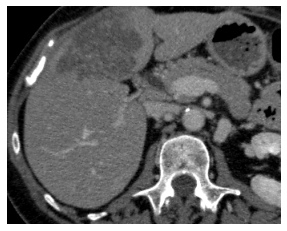

In [ ]:
plt.imshow(volume_n[40],cmap='gray')
plt.axis(False)

(-0.5, 341.5, 271.5, -0.5)

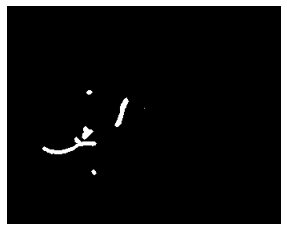

In [ ]:
plt.imshow(vessel_n[40],cmap='gray')
plt.axis(False)

(-0.5, 341.5, 271.5, -0.5)

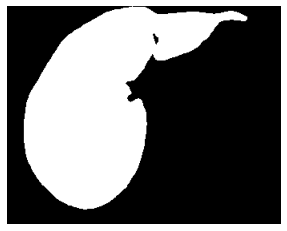

In [ ]:
plt.imshow(liver_n[40],cmap='gray')
plt.axis(False)

(-0.5, 511.5, 511.5, -0.5)

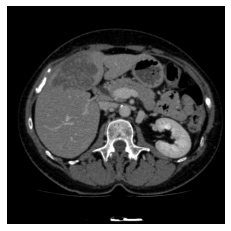

In [ ]:
plt.imshow(volume[67],cmap='gray')
plt.axis(False)

(-0.5, 511.5, 511.5, -0.5)

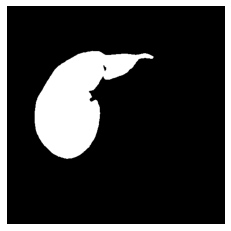

In [ ]:
plt.imshow(liver[67],cmap='gray')
plt.axis(False)

(-0.5, 511.5, 511.5, -0.5)

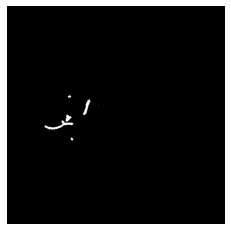

In [ ]:
plt.imshow(vessel[67],cmap='gray')
plt.axis(False)